In [1]:
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate

import pandas as pd
import tqdm
import h5py
from Bio import SeqIO

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# import keras functions
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Input, Flatten, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# performance matrices
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score

# plots
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Lambda, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2

2023-05-09 17:11:11.960753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-09 17:11:11.960787: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def plot_save(history, filename):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.savefig(filename)
    plt.show()
    
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [3]:
def prot_t5_model():
    # prot_t5
    M1_input = Input(shape=(1024,))
    M1_dense_1 = Dense(256)(M1_input)
    drop_out = Dropout(0.4)(M1_dense_1)
   
    M1_dense_2 = Dense(64, activation='relu')(drop_out)
    drop_out = Dropout(0.4)(M1_dense_2)
    #M1_dense_2 = Dense(128, activation='relu')(drop_out)
    #leaky_relu = LeakyReLU(alpha=0.3)(M1_dense_2)
    #drop_out = Dropout(0.7)(leaky_relu)
    M1_dense_3 = Dense(1, activation = 'sigmoid')(drop_out)
    model = Model(inputs=M1_input, outputs=M1_dense_3)
    return model

In [4]:
def read_h5(path):
    hf = h5py.File(path, 'r')
    mat = np.array(hf["embedding"])
    hf.close()
    return mat

In [5]:
test_positive_ST_embedding_pos = read_h5("../embeddings/test_positive_ST_embedding.h5")
test_negative_ST_embedding_pos = read_h5("../embeddings/test_negative_ST_embedding.h5")

In [6]:
test_positive_ST_labels = np.ones(test_positive_ST_embedding_pos.shape[0])
test_negative_ST_labels = np.zeros(test_negative_ST_embedding_pos.shape[0])

test_ST_labels = np.concatenate((test_positive_ST_labels, test_negative_ST_labels), axis = 0)
X_test_full_ST_embedding = np.vstack((test_positive_ST_embedding_pos, test_negative_ST_embedding_pos))

In [7]:
train_positive_ST_embedding_pos = read_h5("../embeddings/train_positive_ST_embedding.h5")
train_negative_ST_embedding_pos = read_h5("../embeddings/train_negative_ST_embedding.h5")

In [8]:
train_positive_ST_labels = np.ones(train_positive_ST_embedding_pos.shape[0])
train_negative_ST_labels = np.zeros(train_negative_ST_embedding_pos.shape[0])

train_ST_labels = np.concatenate((train_positive_ST_labels, train_negative_ST_labels), axis = 0)
X_train_full_ST_embedding = np.vstack((train_positive_ST_embedding_pos, train_negative_ST_embedding_pos))

In [9]:
X_train_full_ST_embedding.shape, train_ST_labels.shape,  X_test_full_ST_embedding.shape, test_ST_labels.shape

((1779, 1024), (1779,), (446, 1024), (446,))

In [10]:
def get_input_for_embedding(fasta_file):
    # This is returning just integers to feed to embedding layer
    
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    #print(char_to_int)
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        for char in data:
            if char not in alphabet:
                return
        integer_encoded = [char_to_int[char] for char in data]
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    print(encodings.shape)
    return encodings


# convert sequences to integer encoding, for embedding
test_positive_ST_CNN = get_input_for_embedding('../dataset/test_Pos_ST.fasta')
test_negative_ST_CNN = get_input_for_embedding('../dataset/test_Neg_ST.fasta')

train_positive_ST_CNN = get_input_for_embedding('../dataset/train_Pos_ST.fasta')
train_negative_ST_CNN = get_input_for_embedding('../dataset/train_Neg_ST.fasta')

(222, 33)
(224, 33)
(890, 33)
(889, 33)


In [11]:
X_train_CNN = np.vstack((train_positive_ST_CNN, train_negative_ST_CNN))
X_test_CNN = np.vstack((test_positive_ST_CNN, test_negative_ST_CNN))
X_train_CNN.shape, X_test_CNN.shape, train_ST_labels.shape, test_ST_labels.shape

((1779, 33), (446, 33), (1779,), (446,))

In [12]:
from tensorflow.keras import backend as K

def CNN_model():
    model = Sequential()
    model.add(Embedding(128, 21, input_length=33))
    model.add(Lambda(lambda x: tf.expand_dims(x, 3)))
    model.add(Conv2D(32, kernel_size=(17, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model


#import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Layer, GlobalAveragePooling1D, Input, GlobalAveragePooling2D
#from tensorflow.keras.layers import Dense, Embedding
#from tensorflow.keras.models import Sequential


class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=rate)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)] #Dense(4 * ff_dim, activation="relu")
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, inputs, training):
        attn_output, attention_scores = self.att(inputs, inputs, inputs, return_attention_scores=True, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output), attention_scores


class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim, mask_zero=True)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
# transformer based embedding model
def transformer_model():
    vocab_size = 21
    embed_dim = 32 #config["embedding_dim"]
    ff_dim = 32 #config["feed_forward_dim"]
    max_len = 33 #config["maximum_path_length"]
    dropout = 0.2 #config["dropout"]
    n_heads = 2

    inputs = Input(shape=(max_len,))
    embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, n_heads, ff_dim)
    x, weights = transformer_block(x)
    x = GlobalAveragePooling1D()(x) #GlobalAveragePooling1D
    x = Dropout(dropout)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs=inputs, outputs=[outputs])

In [28]:
# Pretraining with Phosphorylation dataset

# S
pre_test_positive_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_pos_S.fasta')
pre_test_negative_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_neg_S.fasta')

pre_train_positive_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_pos_S.fasta')
pre_train_negative_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_pos_S.fasta')

# T
pre_test_positive_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_pos_T.fasta')
pre_test_negative_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_neg_T.fasta')

pre_train_positive_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_pos_T.fasta')
pre_train_negative_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_pos_T.fasta')


pre_test_pos_ST_CNN = np.vstack((pre_test_positive_S_CNN, pre_test_positive_T_CNN)) 
pre_test_neg_ST_CNN = np.vstack((pre_test_negative_S_CNN, pre_test_negative_T_CNN))

pre_train_pos_ST_CNN = np.vstack((pre_train_positive_S_CNN, pre_train_positive_T_CNN))
pre_train_neg_ST_CNN = np.vstack((pre_train_negative_S_CNN, pre_train_negative_T_CNN))

(2001, 33)
(2001, 33)
(2001, 33)
(2001, 33)
(2001, 33)
(2001, 33)
(2001, 33)
(2001, 33)


In [29]:
pre_test_pos_ST_CNN.shape, pre_test_neg_ST_CNN.shape, pre_train_pos_ST_CNN.shape, pre_train_neg_ST_CNN.shape

((4002, 33), (4002, 33), (4002, 33), (4002, 33))

In [30]:
pre_test_positive_ST_labels = np.ones(pre_test_pos_ST_CNN.shape[0])
pre_test_negative_ST_labels = np.zeros(pre_test_neg_ST_CNN.shape[0])

pre_test_ST_labels = np.concatenate((pre_test_positive_ST_labels, pre_test_negative_ST_labels), axis = 0)
pre_test_ST_labels.shape

(8004,)

In [31]:
pre_train_positive_ST_labels = np.ones(pre_train_pos_ST_CNN.shape[0])
pre_train_negative_ST_labels = np.zeros(pre_train_neg_ST_CNN.shape[0])

pre_train_ST_labels = np.concatenate((pre_train_positive_ST_labels, pre_train_negative_ST_labels), axis = 0)
pre_train_ST_labels.shape

(8004,)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 33, 21)            2688      
                                                                 
 lambda_1 (Lambda)           (None, 33, 21, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 19, 32)        1664      
                                                                 
 dropout_2 (Dropout)         (None, 17, 19, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 9, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                      

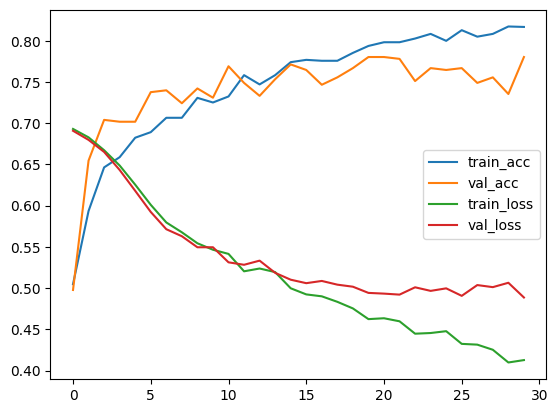


 Acc: 0.7802690582959642, MCC: 0.5609609538543682, SN:0.7972972972972973, SP:0.7633928571428571, 
 CM:[[171  53]
 [ 45 177]]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 token_and_position_embeddin  (None, 33, 32)           1728      
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  ((None, 33, 32),         10656     
 merBlock)                    (None, 2, 33, 33))                 
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
 

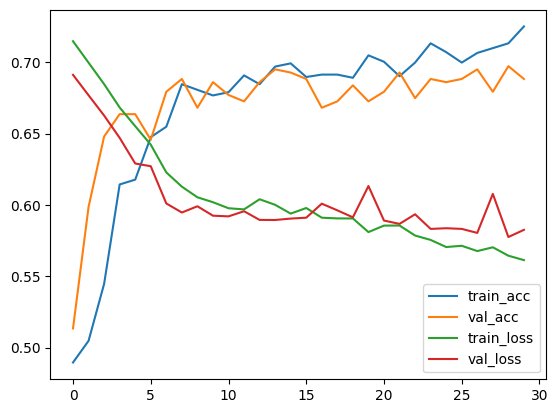


 Acc: 0.6883408071748879, MCC: 0.3772660064974982, SN:0.7117117117117117, SP:0.6651785714285714, 
 CM:[[149  75]
 [ 64 158]]


In [32]:
# Pretraining models

iteration = 1
n_epo_cnn = 30
n_epo = 10

model_A = CNN_model()
model_A.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=['accuracy'])

model_A.summary()

print("PRE Training CNN model...")

metric = 'val_accuracy'

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

history_A = model_A.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo_cnn, verbose=1,callbacks=[],
    validation_data=(X_test_CNN, test_ST_labels))

# Save model
#model_A.save('../models/cv_new/model_A_'+str(iteration)+'.h5')
model_A.save_weights('../models/pre_model_A.h5')

y_pred = model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(history_A)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))


########### Model B

'''print("Training Embedding model...")

model_B = prot_t5_model()
model_B.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,mode='auto')

metric = 'val_accuracy'

history_B = model_B.fit(X_train_full_ST_embedding, train_ST_labels, batch_size=256, epochs=n_epo, verbose=1, callbacks=[], 
                        validation_data=(X_test_full_ST_embedding, test_ST_labels))

model_B.save_weights('../models/model_B.h5')

y_pred = model_B.predict(X_test_full_ST_embedding).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

plot(history_B)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))'''

############# Training Transformer


model_C = transformer_model()
model_C.compile(optimizer=Adam(learning_rate=1e-3),
          loss=BinaryCrossentropy(),
          metrics=['accuracy'])

model_C.summary()

print("PRE Training Transformer model...")

metric = 'val_accuracy'

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

history_C = model_C.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo_cnn, verbose=1,callbacks=[],
    validation_data=(X_test_CNN, test_ST_labels))

# Save model
#model_A.save('../models/cv_new/model_A_'+str(iteration)+'.h5')
model_C.save_weights('../models/pre_model_C.h5')

y_pred = model_C.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(history_C)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

Training CNN model...
Epoch 1/30
7/7 [==============================] - 1s 82ms/step - loss: 0.4039 - accuracy: 0.8263 - val_loss: 0.4943 - val_accuracy: 0.7668
Epoch 2/30
7/7 [==============================] - 1s 96ms/step - loss: 0.4029 - accuracy: 0.8201 - val_loss: 0.4870 - val_accuracy: 0.7780
Epoch 3/30
7/7 [==============================] - 1s 119ms/step - loss: 0.3998 - accuracy: 0.8325 - val_loss: 0.4953 - val_accuracy: 0.7601
Epoch 4/30
7/7 [==============================] - 1s 127ms/step - loss: 0.3817 - accuracy: 0.8319 - val_loss: 0.4879 - val_accuracy: 0.7758
Epoch 5/30
7/7 [==============================] - 1s 130ms/step - loss: 0.3744 - accuracy: 0.8494 - val_loss: 0.4902 - val_accuracy: 0.7758
Epoch 6/30
7/7 [==============================] - 1s 114ms/step - loss: 0.3766 - accuracy: 0.8392 - val_loss: 0.4935 - val_accuracy: 0.7646
Epoch 7/30
7/7 [==============================] - 1s 109ms/step - loss: 0.3696 - accuracy: 0.8499 - val_loss: 0.4962 - val_accuracy: 0.7511


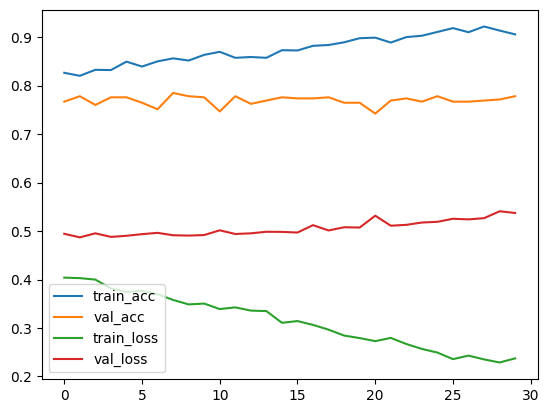


 Acc: 0.7780269058295964, MCC: 0.5574405534151028, SN:0.8108108108108109, SP:0.7455357142857143, 
 CM:[[167  57]
 [ 42 180]]
Training Transformer model...
Epoch 1/30
7/7 [==============================] - 1s 83ms/step - loss: 0.5642 - accuracy: 0.7122 - val_loss: 0.6036 - val_accuracy: 0.6771
Epoch 2/30
7/7 [==============================] - 1s 78ms/step - loss: 0.5729 - accuracy: 0.7066 - val_loss: 0.5875 - val_accuracy: 0.6928
Epoch 3/30
7/7 [==============================] - 1s 78ms/step - loss: 0.5732 - accuracy: 0.7066 - val_loss: 0.5918 - val_accuracy: 0.6883
Epoch 4/30
7/7 [==============================] - 1s 82ms/step - loss: 0.5718 - accuracy: 0.7060 - val_loss: 0.5711 - val_accuracy: 0.6973
Epoch 5/30
7/7 [==============================] - 1s 83ms/step - loss: 0.5531 - accuracy: 0.7240 - val_loss: 0.5833 - val_accuracy: 0.6861
Epoch 6/30
7/7 [==============================] - 1s 81ms/step - loss: 0.5552 - accuracy: 0.7240 - val_loss: 0.5648 - val_accuracy: 0.6996
Epoch 7/30

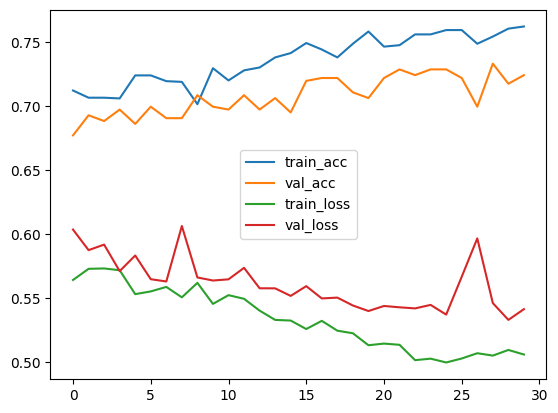


 Acc: 0.7242152466367713, MCC: 0.4656261078152754, SN:0.8558558558558559, SP:0.59375, 
 CM:[[133  91]
 [ 32 190]]


In [33]:
# Training DE-Phosphorylation

iteration = 1
n_epo_cnn = 30
n_epo = 10

#model_A = CNN_model()
#model_A.load_weights("")
#model_A.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=['accuracy'])

#model_A.summary()

print("Training CNN model...")

metric = 'val_accuracy'

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

history_A = model_A.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo_cnn, verbose=1,callbacks=[],
    validation_data=(X_test_CNN, test_ST_labels))

# Save model
#model_A.save('../models/cv_new/model_A_'+str(iteration)+'.h5')
model_A.save_weights('../models/model_A.h5')

y_pred = model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(history_A)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))


########### Model B

'''print("Training Embedding model...")

model_B = prot_t5_model()
model_B.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,mode='auto')

metric = 'val_accuracy'

history_B = model_B.fit(X_train_full_ST_embedding, train_ST_labels, batch_size=256, epochs=n_epo, verbose=1, callbacks=[], 
                        validation_data=(X_test_full_ST_embedding, test_ST_labels))

model_B.save_weights('../models/model_B.h5')

y_pred = model_B.predict(X_test_full_ST_embedding).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

plot(history_B)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))'''

############# Training Transformer


#model_C = transformer_model()
#model_C.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=['accuracy'])

#model_C.summary()

print("Training Transformer model...")

metric = 'val_accuracy'

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

history_C = model_C.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo_cnn, verbose=1,callbacks=[],
    validation_data=(X_test_CNN, test_ST_labels))

# Save model
#model_A.save('../models/cv_new/model_A_'+str(iteration)+'.h5')
model_C.save_weights('../models/model_C.h5')

y_pred = model_C.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(history_C)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [37]:
# load models from file
def load_A_models():
    model_A = CNN_model()
    model_A.load_weights('../models/model_A.h5')
    return model_A


def load_B_models():
    model = prot_t5_model()
    model.load_weights('../models/model_B.h5')
    return model

def load_C_models():
    model = transformer_model()
    model.load_weights('../models/model_C.h5')
    return model


# meta learner
def define_stacked_model(members):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
#             layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
    ensemble_visible = [model.input for model in members]
    ensemble_outputs = [model.output for model in members]
    #print(ensemble_visible)
    #print(ensemble_outputs)
    merge = concatenate(ensemble_outputs)
    hidden = Dense(4, activation='relu', name = 'ds_1')(merge)
#     hidden = Dropout(0.4, name = 'dp_1')(hidden)
#     hidden = Dense(4, activation='relu', name = 'ds_2')(hidden)

#     hidden = Dense(4, activation='relu', name = 'ds_3')(hidden)
#     hidden = Reshape((1,4))(hidden)X_train_embedding_full
#     hidden = Bidirectional(LSTM(32))(hidden)
#     hidden = Dropout(0.4, name = 'dp_2')(hidden)
    output = Dense(1, activation='sigmoid', name = 'ds_4')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    plot_model(model, show_shapes=True, to_file='ensemble_graph.png')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


# fit a model
def fit_stacked_model(model, inputX, inputy):
    X = [inputX for _ in range(len(model.input))]
    inputy_enc = to_categorical(inputy)
    model.fit(X, inputy_enc, epochs=10, verbose=1)   


# prediction
def predict_stacked_model(model, inputX):
    X = [inputX for _ in range(len(model.input))]
    return model.predict(X, verbose=0)


# load all models
members = list()
model_A = load_A_models()
#model_B = load_B_models()
model_C = load_C_models()
members.append(model_A)
#members.append(model_B)
members.append(model_C)

n_epo_stacked = 20


#members = load_all_models(['model_A_1', 'model_B_1'])
print('Loaded %d models' % len(members))
stacked_model = define_stacked_model(members)
#print(X_train_embedding_full.shape, X_train_pt5_full.shape)
# fit_stacked_model(stacked_model, x_test, y_test)
#st_history = stacked_model.fit([X_train_embedding_full, X_train_embedding_full, X_train_embedding_full, X_train_embedding_full, X_train_embedding_full, X_train_pt5_full, X_train_pt5_full, X_train_pt5_full, X_train_pt5_full, X_train_pt5_full],y_train, epochs=10, verbose=1)
st_history = stacked_model.fit([X_train_CNN, X_train_CNN], train_ST_labels, epochs=n_epo_stacked, 
                               verbose=1, validation_data=([X_test_CNN, X_test_CNN], test_ST_labels))

stacked_model.save_weights("../models/composite_model.h5")

Loaded 2 models
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_11_input (InputLayer  [(None, 33)]        0           []                               
 )                                                                                                
                                                                                                  
 embedding_11 (Embedding)       (None, 33, 21)       2688        ['embedding_11_input[0][0]']     
                                                                                                  
 lambda_5 (Lambda)              (None, 33, 21, 1)    0           ['embedding_11[0][0]']           
             

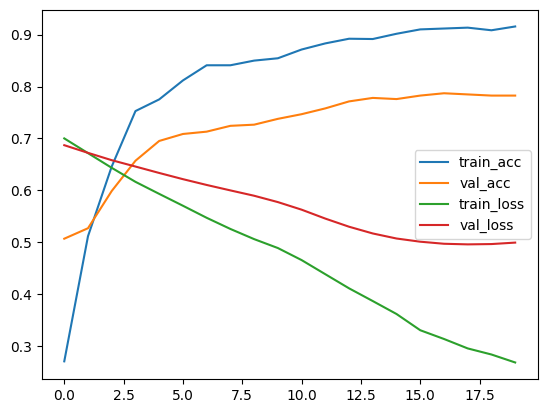


 Acc: 0.7825112107623319, MCC: 0.566089618481451, SN:0.8108108108108109, SP:0.7544642857142857, 
 CM:[[169  55]
 [ 42 180]]


In [38]:
y_pred = stacked_model.predict([X_test_CNN, X_test_CNN]).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

plot(st_history)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [39]:
# load pretrained model
from tensorflow.keras.models import Sequential, load_model, Model
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import h5py

#ANN_model = load_model("../models/composite_model.h5")

print(stacked_model.layers, len(stacked_model.layers))

# create truncated model
truncated_ANN_model = Model(inputs=stacked_model.input,
                                 outputs=stacked_model.get_layer(index=25).output)

hidden_features = truncated_ANN_model.predict([X_test_CNN, X_test_CNN])

print(hidden_features.shape)

df = pd.DataFrame()
df['Target'] = test_ST_labels

[<keras.engine.input_layer.InputLayer object at 0x7f5a9c1e21c0>, <keras.layers.embeddings.Embedding object at 0x7f5a9c1e2400>, <keras.layers.core.lambda_layer.Lambda object at 0x7f5a9c4f5160>, <keras.engine.input_layer.InputLayer object at 0x7f5ab2f7c100>, <keras.layers.convolutional.Conv2D object at 0x7f5ab12ffaf0>, <__main__.TokenAndPositionEmbedding object at 0x7f5ab2f92160>, <keras.layers.core.dropout.Dropout object at 0x7f5ab1280190>, <__main__.TransformerBlock object at 0x7f5a9ed01340>, <keras.layers.pooling.MaxPooling2D object at 0x7f5a67f49550>, <keras.layers.pooling.GlobalAveragePooling1D object at 0x7f5a9ed04070>, <keras.layers.core.flatten.Flatten object at 0x7f5ab2ebc5b0>, <keras.layers.core.dropout.Dropout object at 0x7f5a9ed39b80>, <keras.layers.core.dense.Dense object at 0x7f5ab2ebde20>, <keras.layers.core.dense.Dense object at 0x7f5a9ecc4dc0>, <keras.layers.core.dropout.Dropout object at 0x7f5a9ed59f10>, <keras.layers.core.dropout.Dropout object at 0x7f5a9eccae50>, <ker

ValueError: Was asked to retrieve layer at index 25 but model only has 21 layers.

In [ ]:
m = TSNE(learning_rate = 2, perplexity = 15) #learning_rate = 10, perplexity=30
tsne_features = m.fit_transform(hidden_features)
df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

sns.scatterplot(x="Dimension-1", y="Dimension-2", hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

# plt.axis('off')
# plt.set_xlabel('Subplot 1')
plt.legend().set_visible(False)
filename = "TSNE_ANN_protT5.png"
plt.savefig(filename,dpi=1600,bbox_inches='tight')
plt.show()

In [ ]:
from umap import UMAP
from matplotlib.pyplot import figure

figsize = (8, 8)
figure(figsize=figsize, dpi=150)

n_colors = 10

n_neighbors = 40
min_dist= 0.5

n_components=2

metric='euclidean'

umap_2d = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, init='random', random_state=0)

#tsne_features = m.fit_transform(hidden_features)

#df['Dimension-1'] = tsne_features[:,0]
#df['Dimension-2'] = tsne_features[:,1]

proj_2d = umap_2d.fit_transform(hidden_features)

df_umap = pd.DataFrame()

df_umap["comp-1"] = proj_2d[:,0]
df_umap["comp-2"] = proj_2d[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=test_ST_labels, data=df_umap).set(title="UMAP projection") #palette=sns.color_palette("hls", n_colors)